<a href="https://colab.research.google.com/github/keduog/llama3/blob/main/final_spirograph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

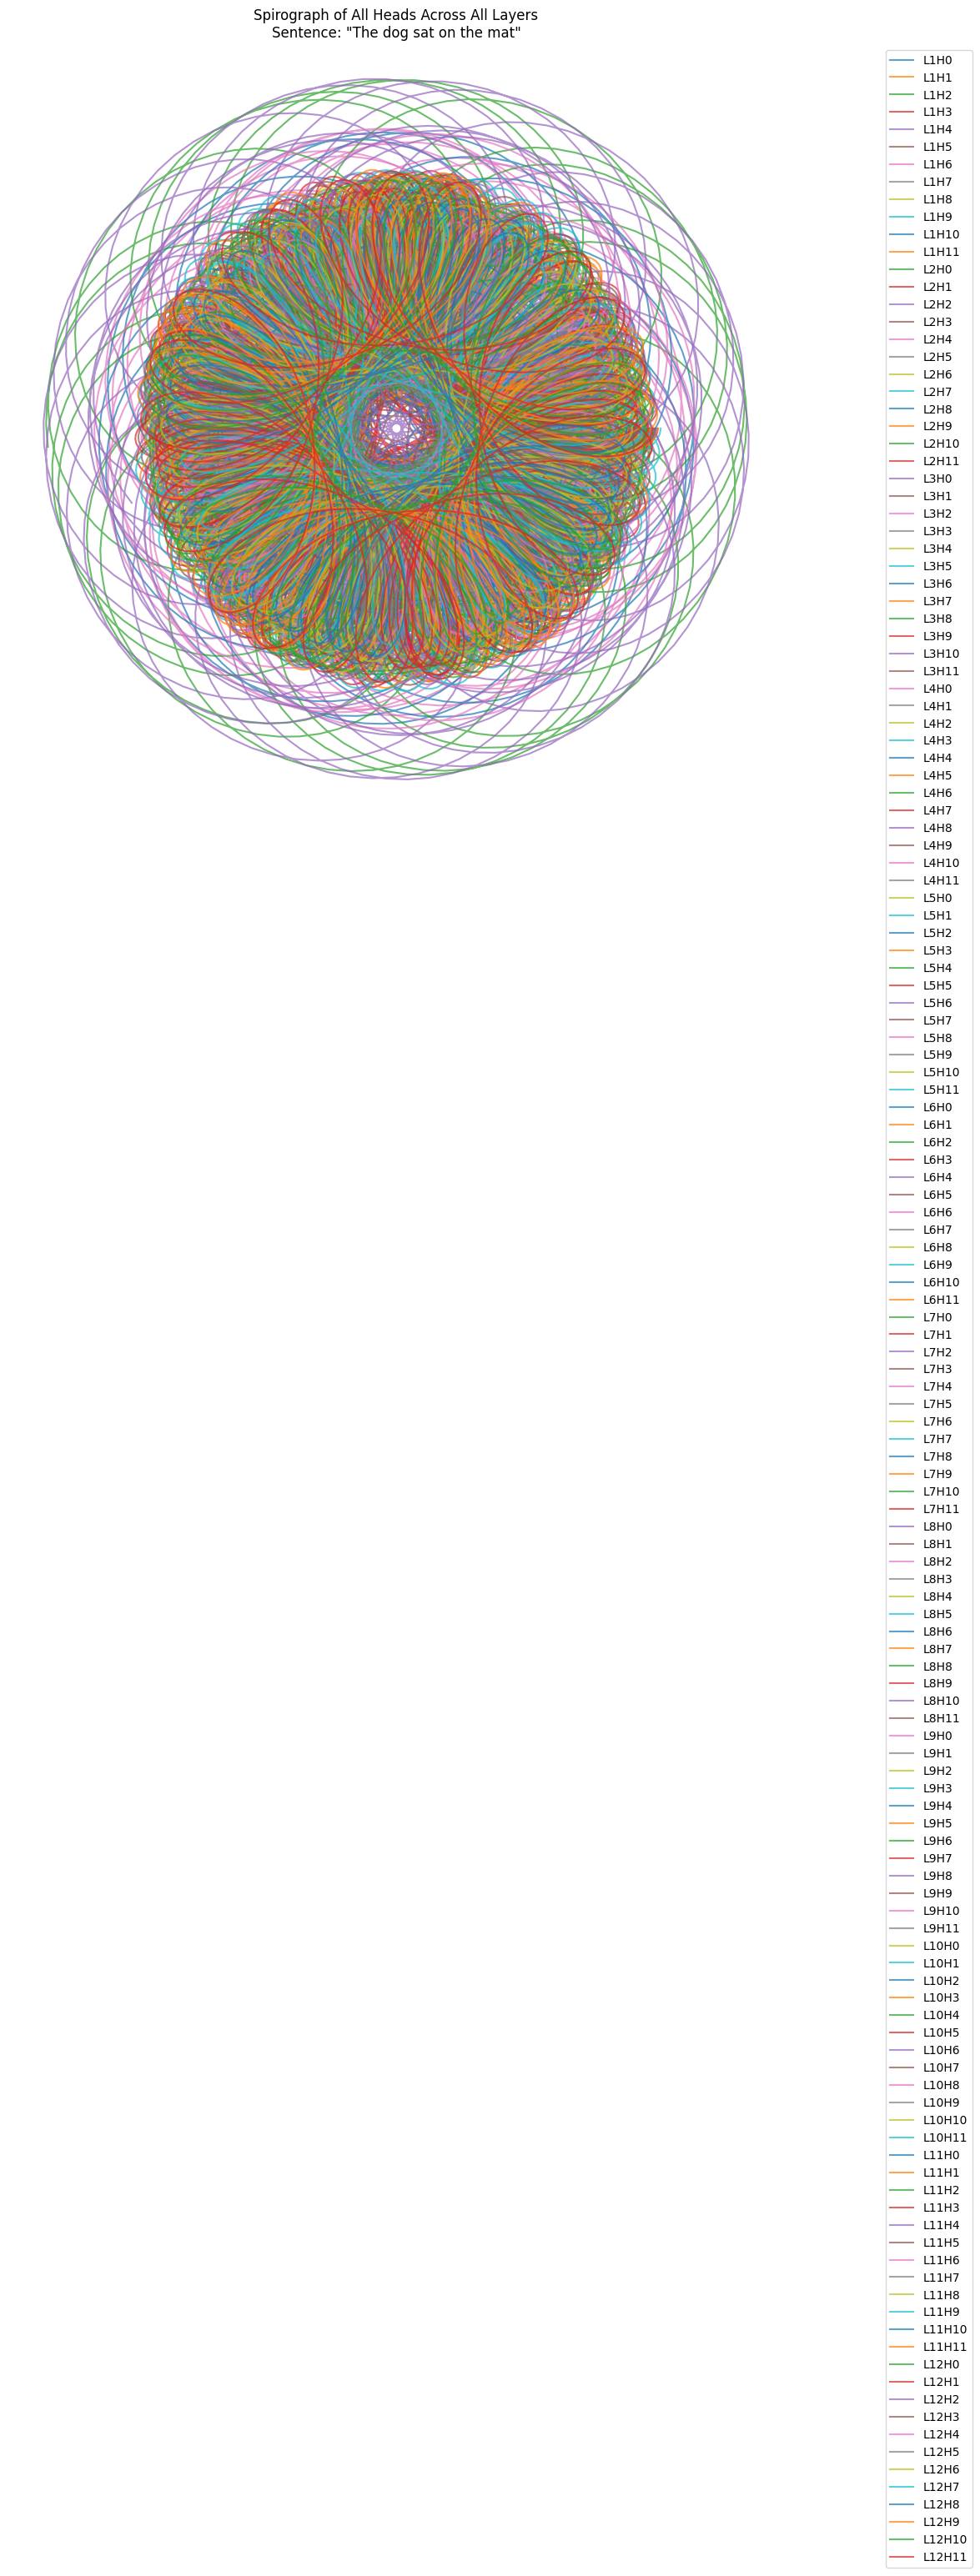

In [2]:
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
model.eval()

def extract_all_layer_head_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states[1:]  # skip embedding layer (len=12 for BERT-base)

    all_heads = []
    for layer in hidden_states:  # loop over each of the 12 layers
        layer = layer.squeeze(0)  # (seq_len, 768)
        heads = layer.view(layer.size(0), 12, 64)  # simulate splitting into 12 heads
        head_embeddings = heads.mean(dim=0)  # (12 heads, 64)
        all_heads.append(head_embeddings)

    # Stack into shape (12 layers × 12 heads, 64 dim)
    all_heads_tensor = torch.cat(all_heads, dim=0)  # (144, 64)
    return all_heads_tensor

def draw_spirograph(R, r, d, x_offset=0, y_offset=0, steps=1000):
    t = np.linspace(0, 2 * np.pi * 5, steps)
    x = (R - r) * np.cos(t) + d * np.cos((R - r) / r * t) + x_offset
    y = (R - r) * np.sin(t) - d * np.sin((R - r) / r * t) + y_offset
    return x, y

def plot_all_heads_spirograph(sentence):
    all_heads = extract_all_layer_head_embeddings(sentence)

    # Project all 144 (12 layers × 12 heads) head embeddings to 2D using PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(all_heads.numpy())

    plt.figure(figsize=(12, 12))
    for idx, (x_val, y_val) in enumerate(reduced):
        layer = idx // 12
        head = idx % 12
        R = 40 + x_val * 10
        r = 10 + abs(y_val) * 5
        d = 20
        x, y = draw_spirograph(R, r, d)
        plt.plot(x, y, label=f"L{layer+1}H{head}", alpha=0.7)

    plt.title(f"Spirograph of All Heads Across All Layers\nSentence: \"{sentence}\"")
    plt.axis("off")
    plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.0))
    plt.show()

# Example usage
plot_all_heads_spirograph("The dog sat on the mat")


<ipython-input-3-9e668b2c79da>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap("tab20", 12)  # 12 distinct colors for 12 layers


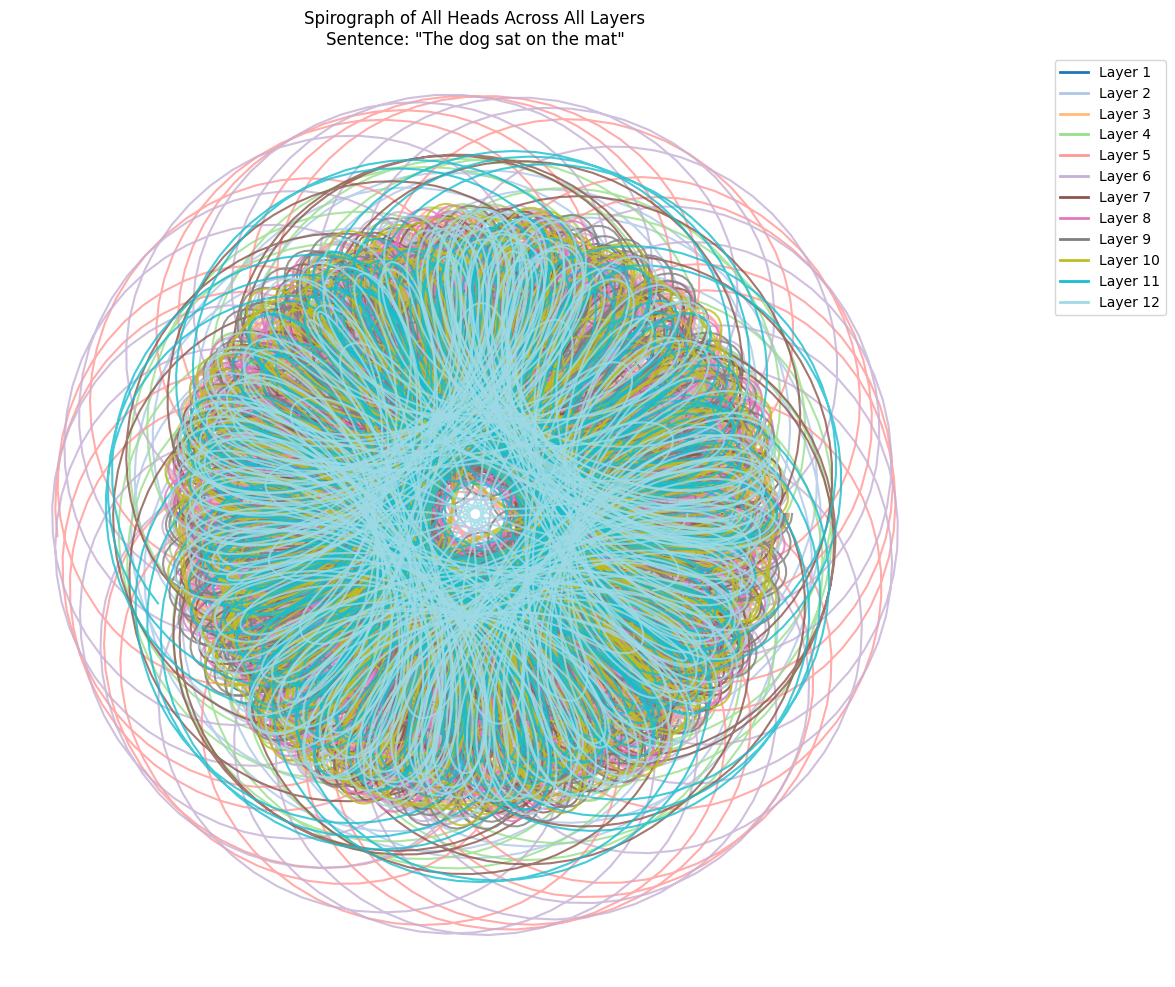

In [3]:
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Load model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
model.eval()

def extract_all_layer_head_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states[1:]  # skip embedding layer

    all_heads = []
    for layer in hidden_states:  # 12 layers
        layer = layer.squeeze(0)  # (seq_len, 768)
        heads = layer.view(layer.size(0), 12, 64)  # (seq_len, 12, 64)
        head_embeddings = heads.mean(dim=0)  # (12, 64)
        all_heads.append(head_embeddings)

    return torch.cat(all_heads, dim=0)  # shape: (12 layers * 12 heads = 144, 64)

def draw_spirograph(R, r, d, x_offset=0, y_offset=0, steps=1000):
    t = np.linspace(0, 2 * np.pi * 5, steps)
    x = (R - r) * np.cos(t) + d * np.cos((R - r) / r * t) + x_offset
    y = (R - r) * np.sin(t) - d * np.sin((R - r) / r * t) + y_offset
    return x, y

def plot_all_heads_spirograph(sentence):
    all_heads = extract_all_layer_head_embeddings(sentence)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(all_heads.numpy())  # (144, 2)

    # Prepare colors for each layer
    color_map = cm.get_cmap("tab20", 12)  # 12 distinct colors for 12 layers

    plt.figure(figsize=(12, 12))
    for idx, (x_val, y_val) in enumerate(reduced):
        layer = idx // 12
        head = idx % 12
        R = 40 + x_val * 10
        r = 10 + abs(y_val) * 5
        d = 20
        x, y = draw_spirograph(R, r, d)
        plt.plot(x, y, label=f"L{layer+1}H{head}", color=color_map(layer), alpha=0.8)

    plt.title(f"Spirograph of All Heads Across All Layers\nSentence: \"{sentence}\"")
    plt.axis("off")
    # Show legend grouped by layer only once per layer
    custom_lines = [plt.Line2D([0], [0], color=color_map(i), lw=2) for i in range(12)]
    plt.legend(custom_lines, [f"Layer {i+1}" for i in range(12)], loc="upper right", bbox_to_anchor=(1.25, 1.0))
    plt.show()

# Example usage
plot_all_heads_spirograph("The dog sat on the mat")


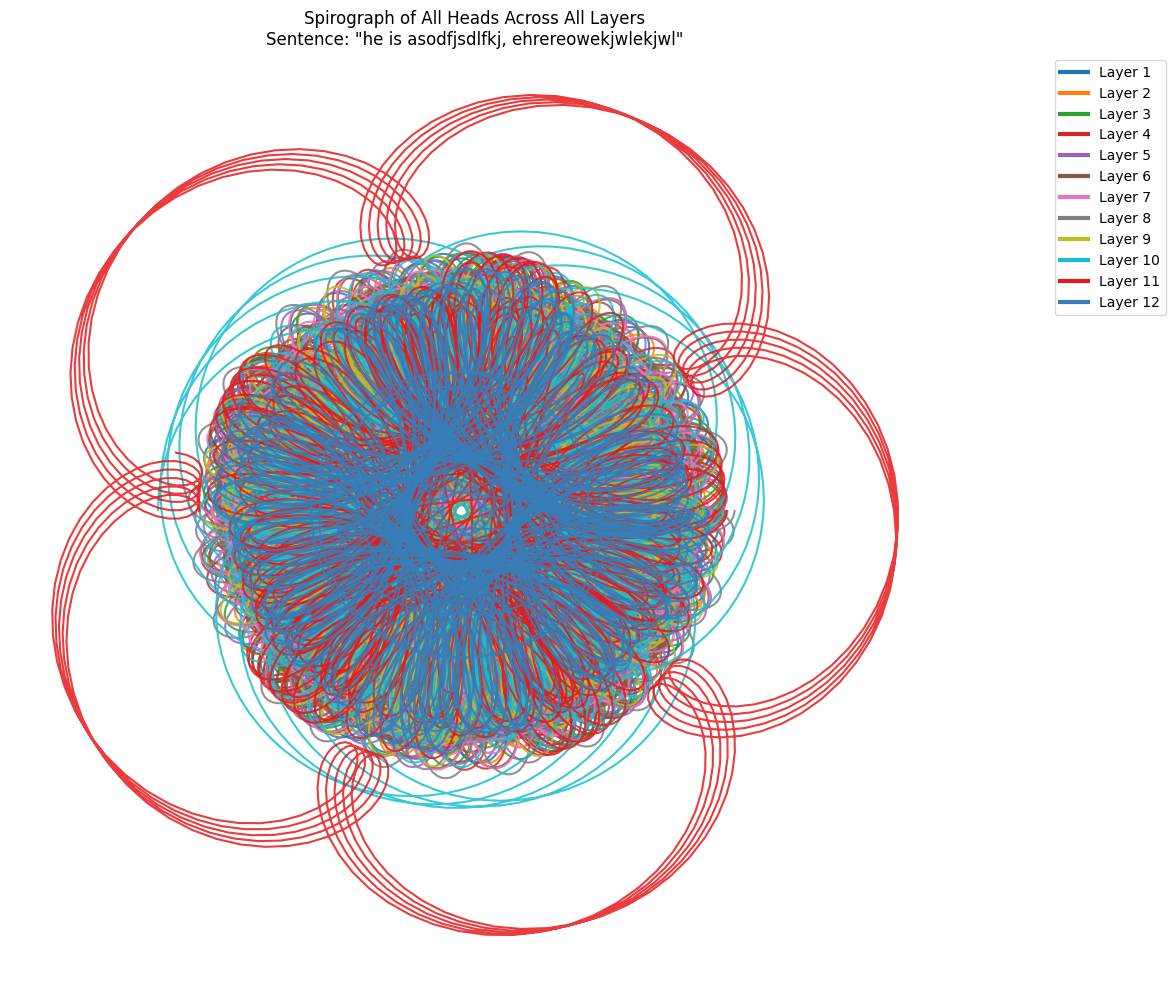

In [17]:
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors

# Load model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
model.eval()

def extract_all_layer_head_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states[1:]  # skip embedding layer

    all_heads = []
    for layer in hidden_states:  # 12 layers
        layer = layer.squeeze(0)  # (seq_len, 768)
        heads = layer.view(layer.size(0), 12, 64)  # (seq_len, 12, 64)
        head_embeddings = heads.mean(dim=0)  # (12, 64)
        all_heads.append(head_embeddings)

    return torch.cat(all_heads, dim=0)  # (144, 64)

def draw_spirograph(R, r, d, x_offset=0, y_offset=0, steps=1000):
    t = np.linspace(0, 2 * np.pi * 5, steps)
    x = (R - r) * np.cos(t) + d * np.cos((R - r) / r * t) + x_offset
    y = (R - r) * np.sin(t) - d * np.sin((R - r) / r * t) + y_offset
    return x, y

def get_distinct_colors(n):
    base_colors = list(mcolors.TABLEAU_COLORS.values())  # 10 very distinct
    extra_colors = [
        "#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00",
        "#ffff33", "#a65628", "#f781bf", "#999999"
    ]
    all_colors = base_colors + extra_colors
    return all_colors[:n]

def plot_all_heads_spirograph(sentence):
    all_heads = extract_all_layer_head_embeddings(sentence)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(all_heads.numpy())  # (144, 2)

    # Get 12 distinct colors
    colors = get_distinct_colors(12)

    plt.figure(figsize=(12, 12))
    for idx, (x_val, y_val) in enumerate(reduced):
        layer = idx // 12
        head = idx % 12
        R = 40 + x_val * 10
        r = 10 + abs(y_val) * 5
        d = 20
        x, y = draw_spirograph(R, r, d)
        plt.plot(x, y, label=f"L{layer+1}H{head}", color=colors[layer], alpha=0.85)

    plt.title(f"Spirograph of All Heads Across All Layers\nSentence: \"{sentence}\"")
    plt.axis("off")
    custom_lines = [plt.Line2D([0], [0], color=colors[i], lw=3) for i in range(12)]
    plt.legend(custom_lines, [f"Layer {i+1}" for i in range(12)], loc="upper right", bbox_to_anchor=(1.25, 1.0))
    plt.show()

# Example usage
plot_all_heads_spirograph("he is asodfjsdlfkj, ehrereowekjwlekjwl")
